In [1]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
import obspy

import DataStructures 
from DayOfData import SeismicData, save_the_waves
from Signal import Signal 

import glob
import pickle
import pandas as pd

import datetime
import time

import os

### Seismic data analysis
We will go over all of our seismic data through the lens of STA-LTA to detect seismic events. DataStructure.py makes the seismic catalogue easily accessible. We can also store the outputs in a convenient folder.

In [2]:
main_folder = 'G:\contenu_D\Gros-Morne\\'

ds = DataStructures.SeisCompP()
_ = ds.scan_directory(r'G:\contenu_D\Gros-Morne\Pegasus')

In [3]:
out_folder = 'output'
try:
    os.makedirs(out_folder)
except OSError:
    pass

If we analyze every possible day, it will take a long time. We can define a proper window for our test analysis.

In [4]:
from obspy.clients.filesystem.sds import Client

root_path = r'G:\\contenu_D\\Gros-Morne\\Pegasus'
client = Client(root_path)

from obspy.core import UTCDateTime
t0 = UTCDateTime('2020-07-18')
t1 = UTCDateTime('2020-07-20')

dt = 3600 * 12
ti = t0 + dt

nbatch = (t1 - t0)/dt

save_fmt = '%Y.%m.%d..%H.%M'

i = 1
while ti <= t1:
    print(f'\rAnalyzing {t0} to {ti}, {i} out of {nbatch:.0f}', end='')
    sd = SeismicData(t0, ti - 1/1000, client)
    windows = sd.multi_stalta(couples=((1, 60), (2.5, 60)),
                                in_threshold=10,
                                out_threshold=2,
                                join_threshold=3,
                                filter_kw=dict(N=5, btype='highpass', Wn=50, fs=1000))
    waves = sd.partition_signal(windows)

    path = os.path.join(out_folder, t0.datetime.strftime(save_fmt) + '_' + ti.datetime.strftime(save_fmt) + '.p')
    save_the_waves(waves, path)

    t0 = ti
    ti += dt
    i += 1




Analyzing 2020-07-19T12:00:00.000000Z to 2020-07-20T00:00:00.000000Z, 4 out of 4

We can now load the isolated waveforms to compute statistics on them. This could easily be paralellized using frameworks such as ``dask`` or ``multiprocessing``.

In [5]:
df = pd.DataFrame()

files = glob.glob(os.path.join(out_folder, '*.p'))

for i, file in enumerate(files):
    
    with open(file, 'rb') as f:
        waves = pickle.load(f)

    for j, w in enumerate(waves):

        print(f'\rFile {i+1} out of {len(files)}, waveform {j+1} out of {len(waves)}', end='')
        
        try:
            df = pd.concat([df, w.statistics()], ignore_index=True, axis=1)
        except Exception as e:
            df = pd.concat([df, pd.Series()], ignore_index=True, axis=1)
            print(e)

df = df.T

df.index = df['DATE']
df.index = pd.DatetimeIndex(df.index)
df = df.drop('DATE', axis=1)

df.to_csv(os.path.join(out_folder, 'waveform_data.csv'))


File 4 out of 4, waveform 253 out of 253

In [10]:
# we can just load the data in case it was already computed
df = pd.read_csv(os.path.join(out_folder, 'waveform_data.csv'))
df.index = pd.DatetimeIndex(pd.to_datetime(df.iloc[:, 0])) - pd.Timedelta(hours=4)
df = df.drop('DATE', axis=1)

### Data analysis

This is where the machine learning fun begins... anything can be done! Let's try PCA. We first need to do a little data preparation. We will take the $\text{log}_{10}$ as well as standardizing the data. We also omit the computed polarization attributes (bearing and plunge) of every geophone as is done in the paper, but they could be kept in.

In [11]:
# We first take the logarithm of a few selected variables... Any transform can be done. The world is your oyster in machine learning.
energy = df.columns.str.contains('ENERGY')
other = df.columns.isin(['DUR', 'RISETIME', 'envMAX', 'envAREA', 'dftAVG', 'dftMAX', 'dftVAR'])
islog = energy | other

Xdf = df.copy()
Xdf.loc[:, islog] = np.log10(Xdf.loc[:, islog])
Xdf = (Xdf - Xdf.mean())/Xdf.std()
Xdf = Xdf.dropna(how='any', axis=1)
Xdf = Xdf.iloc[:, 6:]

Let's try PCA!

(-10.0, 30.0)

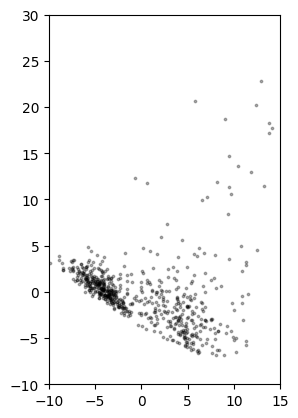

: 

In [13]:
from sklearn.decomposition import PCA

pca = PCA()
X = pca.fit_transform(Xdf)
plt.scatter(X[:, 0], X[:, 1], c='k', alpha=0.3, s=3)
plt.gca().set_aspect(1)
plt.xlim(-10, 15)
plt.ylim(-10, 30)

The PCA already looks similar to the figure produced on the entirety of the data. This is promising! Computing more points would help a lot. Let's go to the next notebook...